In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.cluster import KMeans
from collections import Counter

np.random.seed(0) # For reproducibility
sns.set(style="whitegrid")

## Part A: Baseline Model and Data Analysis (Borrowed from A3)

### Data Loading and Analysis

In [2]:
# Load the dataset
df = pd.read_csv(r"creditcard.csv")

print("Number of datapoints: ", df.shape[0])
print("Number of features: ", df.shape[1])

# Distribution of classes
num_frauds, num_non_frauds = sum(df['Class']), sum(1 - df['Class'])
print("Number of fraudulents: ", num_frauds)
print("Number of Non-Fraud: ", num_non_frauds)
print("\n")
print(f"Non-Fraud : Fraud ratio = {num_non_frauds / num_frauds:.3f}:1")

FileNotFoundError: [Errno 2] No such file or directory: 'creditcard.csv'

- From the analysis made in earlier assignment, the data doesn't have any missing values or doesn't need any further processing

### Model Training

In [ ]:
# Splitting the data, preserving class imbalance
X = np.array(df.drop("Class", axis=1))
y = np.array(df["Class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Degree of Imbalance
print("Degree of Imbalance in Train set: ", sum(1 - y_train) / sum(y_train))
print("Degree of Imbalance in Test set: ", sum(1 - y_test) / sum(y_test))


# Baseline Model with a new variable name
base_logreg_model = LogisticRegression(max_iter=1000, random_state=0, solver="newton-cholesky")
base_logreg_model.fit(X_train, y_train)
y_pred_baseline = base_logreg_model.predict(X_test)

print("---"*20)
print("Baseline Logistic Regression - Classification Report")
print("\n")
print(classification_report(y_test, y_pred_baseline, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))

Degree of Imbalance in Train set:  577.8753387533875
Degree of Imbalance in Test set:  577.8780487804878
------------------------------------------------------------
Baseline Logistic Regression - Classification Report


              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     71079
           1     0.8526    0.6585    0.7431       123

    accuracy                         0.9992     71202
   macro avg     0.9260    0.8292    0.8714     71202
weighted avg     0.9992    0.9992    0.9992     71202

Accuracy: 0.9992135052386169


- The Accuracy is not a good metric here, because the Degree of Imbalance is $\approx$ 578 i.e. there are 578 non-fraud cases per fraud case. 
- So even if the model outputs 0 (predicts everyone as non-fraud), the accuracy would be around 578/579 $\approx$ 0.998. 
- The better metrics to look at here would be **recall** (actual fraction of frauds catched) and **precision** (how reliable the model when the prediction is 1) and **F1 score** which balances between recall and precision

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### Theoretical Foundations

**SMOTE (Synthetic Minority Over-sampling Technique)**

- SMOTE generates new samples by interpolating between existing data points. Think of it like connecting two minority data points with a line and then picking a random spot on that line to create a new, synthetic point.

- This approach can become problematic if your data distribution isn't a single, convex clump. For distributions with multiple distinct clusters (multi-modal), SMOTE can create samples in the low-probability "empty spaces" between the real clusters, which can introduce noise and make the synthetic data less realistic.

**GMM (Gaussian Mixture Model) Sampling**

- A GMM, on the other hand, first models the underlying structure of the data by fitting multiple Gaussian distributions to it. It actively learns the shape, size, and location of each cluster in a multi-modal dataset.

- Because it understands the distribution's inherent structure, GMM can then generate new samples from within these identified clusters. This makes it a much better option for sampling from complex or multi-modal distributions, as the synthetic data it produces is far more likely to be representative of the original data.

### GMM Implementation

- **AIC** : This metric finds a relative measure of information loss. Lower AIC score shows that a lot of data is explained without complexity. 
- **BIC** : This metric is very similar to AIC, but applies a storonger penalty for complex models. Thus, BIC favours simpler models to complex ones.

Size of minority class:  369


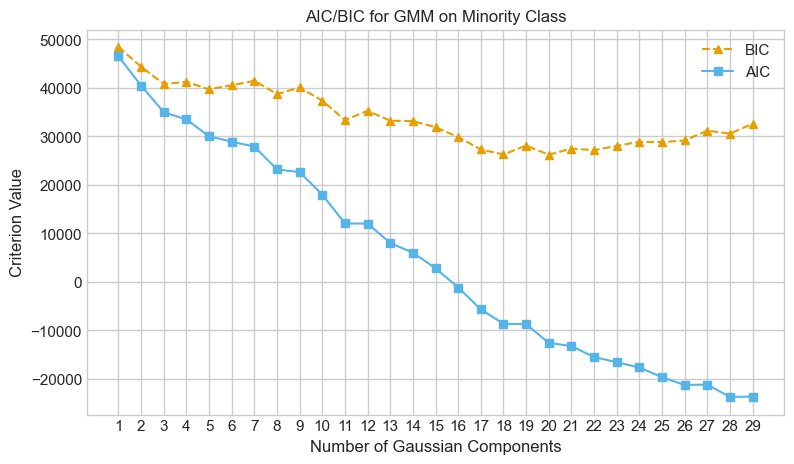

GaussianMixture(n_components=18, n_init=5, random_state=0)

In [ ]:
X_minority = X_train[y_train == 1]
print("Size of minority class: ", len(X_minority))

# Determining the best model using BIC/AIC with new variable names
bic_scores, aic_scores = [], []
num_components_range = range(1, 30)
for n in num_components_range:
    gaussian_mixture = GaussianMixture(n_components=n, covariance_type="full", random_state=0, n_init=5)
    gaussian_mixture.fit(X_minority)
    bic_scores.append(gaussian_mixture.bic(X_minority))
    aic_scores.append(gaussian_mixture.aic(X_minority))


# Plot with a slightly different style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(9,5))
plt.plot(list(num_components_range), bic_scores, marker='^', linestyle='--', color='#E69F00', label='BIC')
plt.plot(list(num_components_range), aic_scores, marker='s', linestyle='-', color='#56B4E9', label='AIC')
plt.xlabel('Number of Gaussian Components')
plt.ylabel('Criterion Value')
plt.title('AIC/BIC for GMM on Minority Class')
plt.legend()
plt.xticks(list(num_components_range))
plt.show()


# Training the best model
optimal_n_components = 18
gaussian_mixture = GaussianMixture(n_components=optimal_n_components, covariance_type="full", random_state=0, n_init=5)
gaussian_mixture.fit(X_minority)

### Synthetic Data Generation

In [ ]:
num_synthetic_samples = round((X_train[y_train == 0].shape[0] / 10)) - X_minority.shape[0]

# Oversample with GMM using new variable names
X_synthetic_data, _ = gaussian_mixture.sample(num_synthetic_samples)
X_minority_oversampled = np.concatenate([X_minority, X_synthetic_data])
y_minority_oversampled = np.ones(len(X_minority) + num_synthetic_samples)

# Combine
X_train_gmm_oversampled = np.concatenate([X_minority_oversampled, X_train[y_train == 0]])
y_train_gmm_oversampled = np.concatenate([y_minority_oversampled, np.zeros(X_train[y_train == 0].shape[0])])

# Shuffle
shuffle_indices = np.random.permutation(len(y_train_gmm_oversampled))
X_train_gmm_oversampled = X_train_gmm_oversampled[shuffle_indices]
y_train_gmm_oversampled = y_train_gmm_oversampled[shuffle_indices]


# Degree of imbalance after Oversampling
print("Degree of Imbalance in Train set after oversampling: ", sum(1 - y_train_gmm_oversampled) / sum(y_train_gmm_oversampled))


Degree of Imbalance in Train set after oversampling:  9.999812417932846


### Rebalancing with CBU

In [ ]:
# Size of majority class 
print("Size of the majority class: ", len(X_train[y_train == 0]))
print("Size of the minority class: ", len(X_train[y_train == 1]))

Size of the majority class:  213236
Size of the minority class:  369


- Meanwhile, size of the minority class is 369 estimated by a GMM with 18 components so each gaussian component on average models 20 points. 
- If I want 100 points from each gaussian in the minority data, that would give me 2,000 minority datapoints in total. 
- If an imbalance ratio of 1:10 is acceptable, I would need about 20,000 majority datapoints.

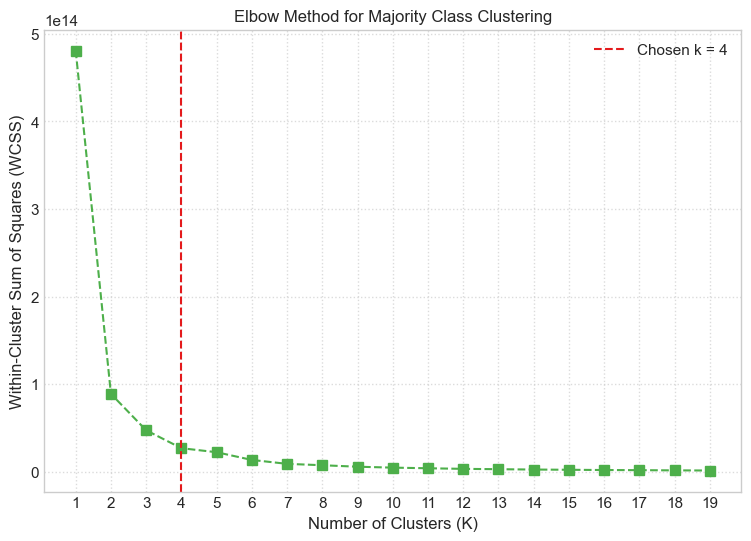

In [ ]:
# CBU
majority_class_data = X_train[y_train==0]

wcss_list = []
k_values = range(1, 20)
for i in k_values:
    kmeans_model = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans_model.fit(majority_class_data)
    wcss_list.append(kmeans_model.inertia_)

# Plot with slightly different styling
plt.figure(figsize=(9,6))
plt.plot(k_values, wcss_list, 's--', color="#4daf4a", markersize=7, linewidth=1.5)
plt.xticks(k_values)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Majority Class Clustering")
plt.grid(True, linestyle=":", alpha=0.7)

chosen_k = 4
plt.axvline(x=chosen_k, color="#ea1b1e", linestyle="--", label=f"Chosen k = {chosen_k}")
plt.legend()
plt.show()

In [ ]:
k_majority = 4
kmeans_for_majority = KMeans(n_clusters=k_majority, random_state=42, n_init='auto')
majority_cluster_labels = kmeans_for_majority.fit_predict(majority_class_data)

In [ ]:
# Undersample proportionally
desired_majority_count = 20_000
undersampled_majority_X_list = []
undersampled_majority_y_list = []

for cluster_label in range(k_majority):
    samples_in_cluster = majority_class_data[majority_cluster_labels == cluster_label]
    num_samples_to_keep = int(len(samples_in_cluster) * desired_majority_count / len(majority_class_data))
    random_indices = np.random.choice(samples_in_cluster.shape[0], size=num_samples_to_keep, replace=True)
    resampled_cluster = samples_in_cluster[random_indices]
    undersampled_majority_X_list.append(resampled_cluster)
    undersampled_majority_y_list.append(np.array([0]*num_samples_to_keep))

X_majority_undersampled = np.concatenate(undersampled_majority_X_list)
y_majority_undersampled = np.concatenate(undersampled_majority_y_list)

In [ ]:
# Oversample with GMM
desired_minority_count = 2_000
num_samples_to_generate = desired_minority_count - len(X_minority)
X_synthetic, _ = gaussian_mixture.sample(desired_minority_count) # Generate total target size
X_minority_resampled = np.concatenate([X_synthetic, X_minority])
y_minority_resampled = np.ones(X_minority_resampled.shape[0])

# Combine
X_train_combined_resampled = np.concatenate([X_minority_resampled, X_majority_undersampled])
y_train_combined_resampled = np.concatenate([y_minority_resampled, y_majority_undersampled])

# Shuffle
final_shuffle_indices = np.random.permutation(len(y_train_combined_resampled))
X_train_combined_resampled = X_train_combined_resampled[final_shuffle_indices]
y_train_combined_resampled = y_train_combined_resampled[final_shuffle_indices]

In [ ]:
# Degree of imbalance after Oversampling with GMM and Undersampling with CBU
print("Degree of Imbalance in Train set after GMM+CBU: ", sum(1 - y_train_combined_resampled) / sum(y_train_combined_resampled))

Degree of Imbalance in Train set after GMM+CBU:  8.44153651329675


## Part C: Performace Evaluation and Conclusion

### Model Training and Evaluation

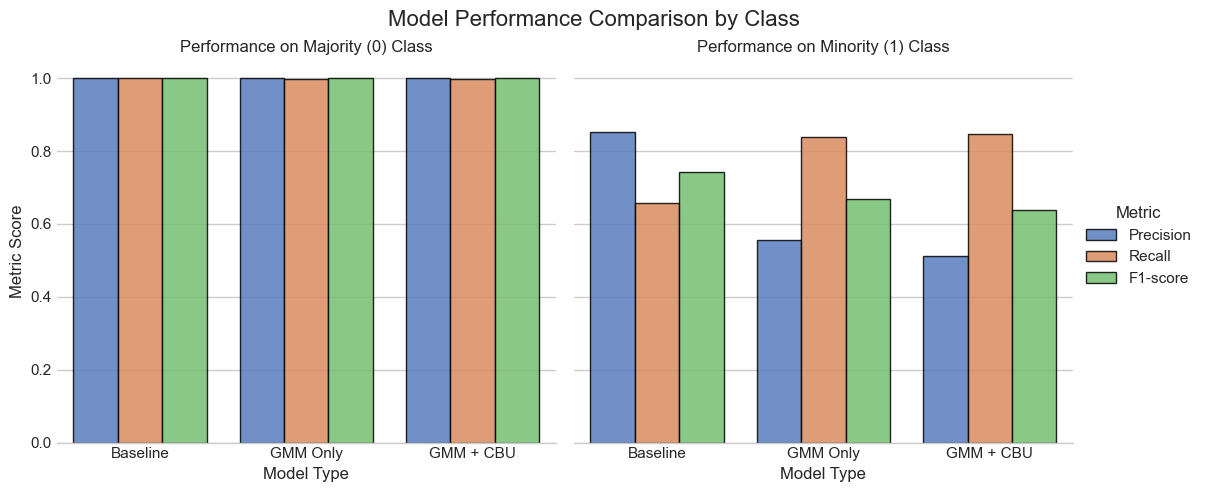

In [ ]:
# Model trained on data oversampled with GMM
logreg_gmm_only = LogisticRegression(max_iter=1000, random_state=0, solver="newton-cholesky")
logreg_gmm_only.fit(X_train_gmm_oversampled, y_train_gmm_oversampled)
y_pred_gmm_only = logreg_gmm_only.predict(X_test)

# Model trained on data with combined GMM oversampling and CBU undersampling
logreg_combined_resampling = LogisticRegression(max_iter=1000, random_state=0, solver="newton-cholesky")
logreg_combined_resampling.fit(X_train_combined_resampled, y_train_combined_resampled)
y_pred_combined_resampling = logreg_combined_resampling.predict(X_test)


# Collect predictions in a dictionary with new variable names
model_predictions = {
    "Baseline": y_pred_baseline,
    "GMM Only": y_pred_gmm_only,
    "GMM + CBU": y_pred_combined_resampling
}

# Build summary table for both classes
performance_data = []
for name, predictions in model_predictions.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None, labels=[0,1])
    performance_data.append([name, "Majority (0)", precision[0], recall[0], f1[0]])
    performance_data.append([name, "Minority (1)", precision[1], recall[1], f1[1]])

performance_df = pd.DataFrame(performance_data, columns=["Model","Class","Precision","Recall","F1-score"])

performance_df_melted = performance_df.melt(id_vars=["Model","Class"], var_name="Metric", value_name="Score")

# Create the plot with a slightly different visual style
plot_grid = sns.catplot(
    data=performance_df_melted,
    x="Model", y="Score", hue="Metric",
    col="Class",
    kind="bar",
    palette="muted",     
    height=5, aspect=1.1,
    edgecolor='black',   
    alpha=0.85           
)

# Adjust titles and layout for clarity
plot_grid.fig.subplots_adjust(top=0.88)
plot_grid.fig.suptitle("Model Performance Comparison by Class", fontsize=16)
plot_grid.set_axis_labels("Model Type", "Metric Score")
plot_grid.set_titles("Performance on {col_name} Class")
plot_grid.despine(left=True)
plt.show()

In [ ]:
from tabulate import tabulate

# Print the DataFrame using a PostgreSQL-style table format
print(tabulate(performance_df, headers='keys', tablefmt='psql'))

+----+-----------+--------------+-------------+----------+------------+
|    | Model     | Class        |   Precision |   Recall |   F1-score |
|----+-----------+--------------+-------------+----------+------------|
|  0 | Baseline  | Majority (0) |    0.999409 | 0.999803 |   0.999606 |
|  1 | Baseline  | Minority (1) |    0.852632 | 0.658537 |   0.743119 |
|  2 | GMM Only  | Majority (0) |    0.999718 | 0.998846 |   0.999282 |
|  3 | GMM Only  | Minority (1) |    0.556757 | 0.837398 |   0.668831 |
|  4 | GMM + CBU | Majority (0) |    0.999732 | 0.998607 |   0.999169 |
|  5 | GMM + CBU | Minority (1) |    0.512315 | 0.845528 |   0.638037 |
+----+-----------+--------------+-------------+----------+------------+


### Final Recommendation

**Observations**
- The baseline models suffers due to very low Recall on minority datapoints.
- The objective of this exercise is to attain higher trigger rates on the Minority datapoints, and thus the Baseline model does not perform adequately.
- GMM+CBU model seems to have very good recall, and is the best pipeline in that metric.